In [48]:
%matplotlib inline


# 神经网络

神经网络可以使用 ``torch.nn``包来构建。

已经简单学习过了 ``autograd``, ``nn``是依赖 ``autograd``去定义模型以及对其求导。一个``nn.Module``包含层(layers)，和一个方法``forward(input)``(方法返回``output``)。

例如，来看一下这个用来分类数字图像的网络：
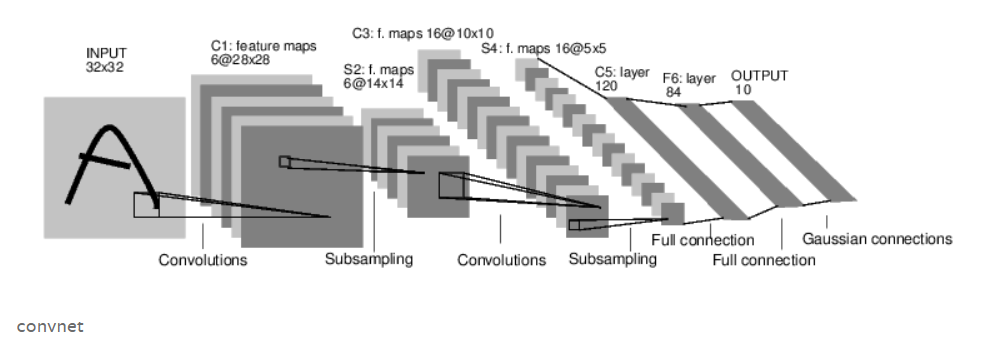

这是一个简单的前馈网络。它接受输入，一个接一个地通过几个层为其提供数据，最后给出输出。

一个典型的神经网络训练过程如下：
- 定义一个有一些可学习参数(权重)的神经网络
- 遍历输入数据集
- 通过网络处理输入
- 计算损失(输出距离正确有多远)
- 反向传递梯度给网络的参数
- 更新网络的权重，通常使用一个简单的更新规则:``weight = weight - learning_rate * gradient``


## 定义网络

定义一个网络:



In [49]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 输入图像一个通道，输出6通道，3*3卷积
        # kernel
        self.conv1 = nn.Conv2d(1, 6, 3) # Con2d(#channel, #number, #side length)
        self.conv2 = nn.Conv2d(6, 16, 3)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 6 * 6, 120)  # 6*6 from image dimension 
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x)) #展平
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


你只需要定义 ``forward``函数，``backward``函数(计算梯度)是在使用``autograd``时自动定义的。可以在``forward``函数中使用任意的Tensor操作。

模型的可学习参数由``net.parameters()``返回。



In [50]:
params = list(net.parameters())
print(len(params)) #一共5层，每层两种参数W, b
print(params[0].size())  # conv1's .weight

10
torch.Size([6, 1, 3, 3])


尝试随机地输入32\*32矩阵。
注意：这个网络(LeNet)的输入size是32\*32。要在MNIST数据集上使用这个网络，请将数据集中的图像缩放至32\*32。

In [51]:
input = torch.randn(1, 1, 32, 32)
out = net(input)
print(out)

tensor([[ 0.1086,  0.0235,  0.0029, -0.1187,  0.0323, -0.0976, -0.0289, -0.0658,
         -0.0145, -0.0298]], grad_fn=<AddmmBackward>)


将所有参数和背景的梯度缓冲器均设置为零，随机设置梯度：



In [52]:
net.zero_grad()
out.backward(torch.randn(1, 10))

>``torch.nn``只支持小批量(mini-batches)。整个的``torch.nn``只支持小批量的样本输入，不支持单个样本。
例如，``nn.Conv2d``接收一个4D的Tensor``nSamples x nChannels x Height x Width``。如果你有一个单样本，只要使用``input.unsqueeze(0)``去增加一个假的batch维度。

In [53]:
sample = torch.randn(1, 32, 32)
print(sample.size())
sample.unsqueeze_(0) #在第0维前面增加一个维度
print(sample.size())

torch.Size([1, 32, 32])
torch.Size([1, 1, 32, 32])


再来温习一下目前为止已经看到过的类。

**温习:**
  -  ``torch.Tensor`` - 一个多维的数组，支持例如 ``backward()``的自动求导。也包含了关于tensor的梯度。
  -  ``nn.Module`` - 神经网络模块。封装参数的便捷方式，能够将它们移动到GPU，导出，加载等。
  -  ``nn.Parameter`` - 一种Tensor，当被作为一种属性被分配给``Module``时，自动注册为一个参数。
  -  ``autograd.Function`` - 实现自动求导操作的前向和反向传递定义。每个``Tensor``操作至少创建一个``Function``结点，结点与创建``Tensor``的函数连接，编码它的历史。 
  
**目前，我们能够:**
  -  定义一个神经网络
  -  处理输入和调用backward

**还剩下:**
  -  计算loss
  -  更新网络权重
  

## 损失函数Loss Function

一个损失函数接收(output, target)作为输入，计算一个评估output距离target还有多远的值。

在nn包中有不同的[loss functions](<https://pytorch.org/docs/nn.html#loss-functions>)。一个简单的loss是``nn.MSELoss``，它计算output和target之间的均方根误差。

例如：

In [54]:
output = net(input)
target = torch.randn(10)  # 一个假设的target
target = target.view(1, -1)  # shape要和output一样
criterion = nn.MSELoss()
loss = criterion(output, target)
print(loss)

a = output.detach().numpy()
b = target.detach().numpy()
print(((a-b)**2).mean())


tensor(0.8940, grad_fn=<MseLossBackward>)
0.89396685


Now, if you follow ``loss`` in the backward direction, using its
``.grad_fn`` attribute, you will see a graph of computations that looks
like this:
现在，如果沿着``loss``的方向向后移动，使用它的``.grad_fn``属性，将会看到如下的计算图：

    input -> conv2d -> relu -> maxpool2d -> conv2d -> relu -> maxpool2d
          -> view -> linear -> relu -> linear -> relu -> linear
          -> MSELoss
          -> loss

所以，当我们调用``loss.backward()``，整个计算图都会被微分，即loss以及所有图中``requires_grad=True``的Tensors都将会随着梯度累积它们的``.grad`` Tensor。

为了说明这一点，让我们跟着backward走几步:



In [55]:
print(loss.grad_fn)  # MSELoss
print(loss.grad_fn.next_functions[0][0])  # Linear
print(loss.grad_fn.next_functions[0][0].next_functions[0][0])  # ReLU

## 反向传递Backprop

要反向传递误差，我们只需要调用``loss.backward()``。不过，你需要清除现有的梯度，否则梯度将累积为现有梯度。

现在我们将调用``loss.backward()``，并看一看conv1的偏差(bias)梯度在backward前后的值。



In [56]:
net.zero_grad()     # zeroes the gradient buffers of all parameters

print('conv1.bias.grad before backward')
print(net.conv1.bias.grad)

loss.backward()

print('conv1.bias.grad after backward')
print(net.conv1.bias.grad)

conv1.bias.grad before backward
tensor([0., 0., 0., 0., 0., 0.])
conv1.bias.grad after backward
tensor([-0.0140, -0.0052,  0.0125,  0.0011,  0.0038, -0.0026])


Now, we have seen how to use loss functions.
现在，我们来看看如何使用损失函数。

**延展阅读:**

  神经网络包包含各种模块和损失函数，它们组成了用来构建深度神经网络的块。一个完整的列表在文件[here](<https://pytorch.org/docs/nn>)中。

**唯一还需要学习的是:**

  - 更新网络的权重

## 更新权重

实践中最简单的更新规则是随机梯度下降(SGD):

     ``weight = weight - learning_rate * gradient``

我们可以用最简单的python代码来实现：
```python

    learning_rate = 0.01
    for f in net.parameters():
        f.data.sub_(f.grad.data * learning_rate)
```

使用神经网络时，也可以使用各种不同的更新规则，例如SGD，Nesterov-SGD, Adam, RMSProp等。我们构建了一个小包来实现这些：``torch.optim``，它实现了各种更新方法，用起来很简单：


In [57]:
import torch.optim as optim

# create your optimizer
optimizer = optim.SGD(net.parameters(), lr=0.01)

# in your training loop:
optimizer.zero_grad()   # zero the gradient buffers
output = net(input)
loss = criterion(output, target)
loss.backward()
optimizer.step()    # 更新

> 需要使用optimizer.zero_grad()手动将梯度缓冲区设置为零，这是因为`Backprop`节中解释过的梯度会累积。



**总结流程：**

 - 构建网络结构(layer+forward方法)
 - 给出输入，得到输出
 - 定义损失函数criterion，计算loss
 - loss.backward()反向传递
 - 定义optimizer，更新权重